Installs:

In [ ]:
!pip install kaggle --upgrade # for kaggle download
!pip install -U sentence-transformers # for SBERT pre-trained download
!pip install torch-geometric
!pip install pyg-lib torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-1.13.1+cu116.html

##### Imports:

In [ ]:
import os
import pandas as pd
import numpy as np
import random
from random import sample
import pickle
from IPython.display import HTML, display
from google.colab import drive
import torch
import torch.nn as nn
from torch_geometric.nn import Sequential, GCNConv
from sentence_transformers import util
import matplotlib 
import matplotlib.pyplot as plt 
from matplotlib.patches import Rectangle

##### Choose an input graph to load:

Graph initialization code: https://colab.research.google.com/drive/1Ygsy2a8sxpipOSKXys2cwIzeMyN4iEXz?authuser=3#scrollTo=6L_t_4ilqiAp

Print all save graphs:

In [ ]:
drive.mount('/content/drive') 

In [ ]:
saved = os.listdir("/content/drive/My Drive/J-Term 2023/input-graphs")
t=[print(str(i)+": "+saved[i]) for i in range(len(saved))]

Select and load a graph of choice

In [ ]:
class Node():
  def __init__(self, embedding, engl, edges, edgeweights, idx):
    self.emb = embedding # onehot or pre-embed encoding
    self.en = engl # english word
    self.edges = edges # list of connected edges
    self.edgew = edgeweights # edgeweights corresponding to edges
    self.idx = idx # node index

In [ ]:
def Load(graphname):
    with open("/content/drive/My Drive/J-Term 2023/input-graphs/" + graphname, "rb") as pkl_handle:
        output = pickle.load(pkl_handle)
        print("loaded: "+graphname)
        return output

loaded_graph = Load(saved[0])

In [ ]:
def Load(): # for a second acc
    with open("/content/drive/My Drive/init-graph-word2vec-.45thresh.txt", "rb") as pkl_handle:
        output = pickle.load(pkl_handle)
        print("loaded")
        return output

loaded_graph = Load()

In [ ]:
print(loaded_graph['orchard'].emb.shape)
print(loaded_graph['orchard'].edges)

##### Load in the co-occurrence matrix:

Comatrix initialization code: https://colab.research.google.com/drive/1UTmO27hYl1uUQbMqPZO5jKkEcHUrbKTM?authuser=3#scrollTo=k8BiLaGaxcp3

Import the words dataset:

In [ ]:
# downloading kaggle noun dataset - only need to run once
os.environ['KAGGLE_USERNAME'] = ''
os.environ['KAGGLE_KEY'] = ''
!kaggle datasets download -d leite0407/list-of-nouns # https://www.kaggle.com/datasets/leite0407/list-of-nouns
!unzip list-of-nouns.zip
# cleaning the data
nouns = pd.read_csv('nounlist.csv').values.tolist()
for i in range(len(nouns)):
  nouns[i]=nouns[i][0]

Create a reference dictionary that maps words to indicies:

In [ ]:
words_dict = {}
for i in range(len(nouns)):
  words_dict.update({nouns[i].lower(): i})

Download from google drive and normalize the entries:

In [ ]:
with open('/content/drive/My Drive/comatrix3.npy', 'rb') as f: 
  comatrix=np.load(f, allow_pickle=True)

log_nozero = np.vectorize(lambda x: np.log(x) if x>1 else 0)
log_comat = np.array([log_nozero(x) for x in comatrix]) # normalize by taking log
del(comatrix)

Create a positive pairs list from the comatrix:

In [ ]:
pospairs_list = [(x,y) for (x, y), element in np.ndenumerate(log_comat) if element>1.9] # create a list of positive pairs
del(log_comat) # delete the comatrix from runtime RAM
print(len(pospairs_list))

187231


##### Constructing an unweighted GNN class:

References:

1.   https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html
2.  https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv
3. https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html

In [ ]:
class unweightedGNN(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = Sequential('x, edge_index', [ # number of layers is arbitrary...
        
         (GCNConv(6800, 3400), 'x, edge_index -> x'),
         (nn.ReLU(inplace=True)),
         #(nn.Dropout()),

         (GCNConv(3400, 1700), 'x, edge_index -> x'),
         (nn.ReLU(inplace=True)),
         #(nn.Dropout()),

         (GCNConv(1700, 850), 'x, edge_index -> x'),
         (nn.ReLU(inplace=True)),
         #(nn.Dropout()),

         (GCNConv(850, 425), 'x, edge_index -> x'),
         (nn.ReLU(inplace=True)),
         #(nn.Dropout()),

         (nn.Linear(425, 425)),
         (nn.ReLU())
    ])

  def forward(self, x, edges, edgeweights): # x is a tensor holding the one-hot encodings for the words    
    return(self.layers(x, edges)) # apply softmax so all vectors are of the same magnitude

In [ ]:
class weightedGNN(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = Sequential('x, edge_index, edge_weights', [
        
         (GCNConv(6800, 3400), 'x, edge_index, edge_weights -> x'),
         (nn.ReLU(inplace=True)),
         #(nn.Dropout()),

         (GCNConv(3400, 1700), 'x, edge_index, edge_weights -> x'),
         (nn.ReLU(inplace=True)),
         #(nn.Dropout()),

         (GCNConv(1700, 850), 'x, edge_index, edge_weights -> x'),
         (nn.ReLU(inplace=True)),
         #(nn.Dropout()),

         (GCNConv(850, 425), 'x, edge_index, edge_weights -> x'),
         (nn.ReLU(inplace=True)),
         #(nn.Dropout()),

         (nn.Linear(425, 425)),
         (nn.ReLU())
    ])

  def forward(self, x, edges, edgeweights): # x is a tensor holding the one-hot encodings for the words    
    return(self.layers(x, edges, edgeweights))

Creating edges and edgeweights tensors to pass into the GNN:

In [ ]:
edges = []
edgews = []

edges = [[],[]]
for key in loaded_graph:
  lgk = loaded_graph[key]
  for i in range(len(lgk.edges)):
    #edges.append([lgk.idx, loaded_graph[lgk.edges[i]].idx])
    edges[0].append(lgk.idx)
    edges[1].append(loaded_graph[lgk.edges[i]].idx)
    edgews.append(lgk.edgew[i])

edges = torch.from_numpy(np.array(edges))
edgews = torch.from_numpy(np.array(edgews))

print("Number of edges: " + str(len(edges[0])))
print("Avg edge count per node: " + str(len(edges[0])/len(loaded_graph)))

##### Create a onehot encoding function

In [ ]:
def onehot_arr(word):
  v = np.zeros(len(nouns))
  v[nouns.index(word)] = 1
  return v

##### Contrastive loss function:

In [ ]:
def getLoss(model_outp, reps, pospairs_list):
  loss = 0
  for i in range(reps):
    # negative pairs: + sum (<modeloutp[x1], modeloutp[x2]>-comatrix[x1, x2])^2
    (nx1, nx2) = (random.randint(0, len(model_outp)-1), random.randint(0, len(model_outp)-1))
    #negfn = lambda a: torch.pow(torch.exp(a)+1, 1)
    negfn = lambda a: torch.pow((1+a), 2)
    loss += negfn(torch.dot(model_outp[nx1], model_outp[nx2]))

    # positive pairs: - sum(<modeloutp[x1], modeloutp[x2]>-comatrix[x1, x2])
    (px1, px2) = pospairs_list[random.randint(0, len(pospairs_list)-1)]
    #posfn = lambda a: torch.log(a+1) # dont let a be a decimal and send loss to inf
    posfn = lambda a: torch.pow((1+a), 1.5)
    loss -= posfn(torch.dot(model_outp[px1], model_outp[px2]))

    #loss /= 10000 # make it more visually readable
  return loss

##### Initialize our device, model, input, and optimizer

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = unweightedGNN().to(device)
model.double()
x = torch.from_numpy(np.array([onehot_arr(x) for x in nouns])).to(device) # input
optimizer = torch.optim.Adam(model.parameters(), lr=0.0002, weight_decay=5e-4)

# put our edges and edgeweights on GPU if available:
edges = edges.to(device)
edgews = edgews.to(device)

##### Train the model:

In [ ]:
def embed(word, graph): # get the embedding of a word based on the model
  return graph[words_dict[word]].detach().cpu().numpy()

model.double() # convert all layers to process doubles instead of floats bc we have input of type double?
batch_size = 8000
epochs = 20
epoch5loss = 0

words = ['tree', 'dirt', 'worm', 'time', 'day']
embeddings = []
for epoch in range(epochs):
    optimizer.zero_grad()
    out = model(x, edges, edgews)
    loss = getLoss(out, batch_size, pospairs_list) # reps should be proportional to len(pospairs_list)
    epoch5loss += round(loss.item(), 2)
    if(epoch!=0 and epoch%1==0):
      print("epoch: "+str(epoch)+ ", loss: "+str(epoch5loss/1000)) # 8000 batch size
      embeddings.append([embed(word, out) for word in words]) # create an embeddings matrix
      epoch5loss=0
    loss.backward()
    optimizer.step()

# do it one more time, on EVAL this time to ignore dropout
optimizer.zero_grad()
model.eval()
out = model(x, edges, edgews)
loss = getLoss(out, batch_size, pospairs_list)
print("Loss on eval: "+str(round(loss.item()/1000, 2)))

In [ ]:
# from word2vec demo: https://colab.research.google.com/drive/15jYCT9ml8fhMvMWsU7PAOJCURdyvWt5_?authuser=3#scrollTo=eT_s4422gMUw

def make_vis(embeddings):
  embed_dim = 425
  # visualize it
  num_embed = len(embeddings)
  cmap = matplotlib.cm.coolwarm
  fig, axes = plt.subplots(num_embed, 1)
  norm = matplotlib.colors.Normalize(vmin=embeddings[0].min(), vmax=embeddings[0].max())
  for idx in range(num_embed):
    ax = axes[idx]
    embedding = embeddings[idx]
    for i in range(embed_dim):
      ax.add_patch(Rectangle((i/embed_dim, 0),.05,1, color=cmap(norm(embedding[i]))))
    ax.text(1.02, .5, words[idx], fontsize=12)
    ax.axis('off')
  plt.show

Display embeddings

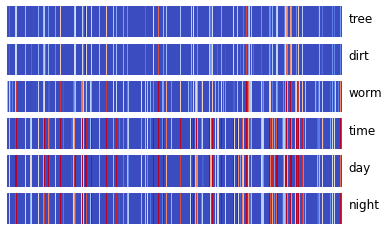

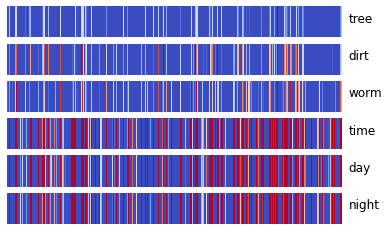

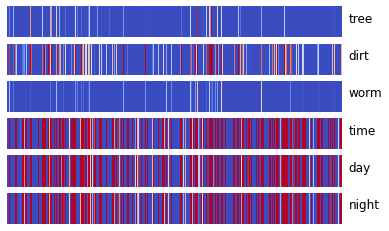

In [ ]:
import time
for i in range(len(embeddings)):
  if((i+1)%5==0):
    make_vis(embeddings[i])

In [ ]:
import seaborn as sn
from sentence_transformers import SentenceTransformer # pretrained sbert: https://www.sbert.net/
from sentence_transformers import util

words = ['tree', 'dirt', 'worm', 'time', 'day']
sims = []

for i in range(len(words)):
  sims.append([])
  for j in range(len(words)):
    sims[i].append(util.cos_sim(out[words_dict[words[i]]], out[words_dict[words[j]]]).item())


df = pd.DataFrame({words[0]:[sims[0][0], sims[0][1], sims[0][2], sims[0][3], sims[0][4]],
                   words[1]:[sims[1][0], sims[1][1], sims[1][2], sims[1][3], sims[1][4]],
                   words[2]:[sims[2][0], sims[2][1], sims[2][2], sims[2][3], sims[2][4]],
                   words[3]:[sims[3][0], sims[3][1], sims[3][2], sims[3][3], sims[3][4]], 
                   words[4]:[sims[4][0], sims[4][1], sims[4][2], sims[4][3], sims[4][4]]},
                   index =[words])


sn.heatmap(df, cmap="YlGnBu")


plt.show()

##### Test the model:

In [ ]:
def compareNext(words, graph):
  comparisons = []
  if(len(words) > 1):
    for i in range(1, len(words)):
      comparisons.append([words[0]+" x "+words[i]+"", util.cos_sim(graph[words_dict[words[0]]], graph[words_dict[words[i]]]).item()])
    for c in compareNext(words[1:], graph):
      comparisons.append(c)
  return comparisons


words = ['tree', 'dirt', 'worm', 'time', 'day', 'night']

comps = compareNext(words, out)
comps.sort(key=lambda x:x[1])
comps.reverse()

split = False
for item in comps:
  if(item[1] < .7 and not split):
    print("------------------")
    split = True
  print(item[0]+": "+str(item[1]))

##### Saving:

Save the output graph to drive:

In [ ]:
os.listdir("/content/drive/My Drive")

In [ ]:
name = 'unweighted-50x8000x-comat3-feb3-9:14'
torch.save(out, '/content/drive/My Drive/'+name+'.pt')

Save the model to drive (if you want):

In [ ]:
torch.save(model.state_dict(), '/content/drive/My Drive/'+name)

Load a model from drive:

In [ ]:
name = ""
model = unweightedGNN().to(device)
model.load_state_dict(torch.load('/content/drive/My Drive/J-Term 2023/saved-models/'+name))
model.double()
model.eval()